In [317]:
import numpy
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '/home/alger/repos/coda/codes/')
import CodaPCA

import cmocean
import sklearn.svm

In [318]:
import importlib
import generate_spectra
importlib.reload(generate_spectra)

<module 'generate_spectra' from '/home/alger/repos/brushtail/generate_spectra.py'>

In [319]:
freqs = numpy.loadtxt('/home/alger/possum/alger/COSMOLOGY_22/freqs.txt')

In [320]:
# freqs = numpy.load('/home/alger/possum/alger/jack_freqs.npy')
spectra = generate_spectra.generate_spectra(freqs, n_spectra=10000, phi_sampling=500, max_noise=0.8)

100%|██████████| 10000/10000 [00:02<00:00, 4119.34it/s]


In [321]:
pca = CodaPCA.CodaPCA(3, 0.01, [10, 10], alg=CodaPCA.Alg.CODAAE)

In [322]:
features = abs(spectra['sim_fdf'])
features.shape

(10000, 500)

In [324]:
tf = pca.fit_transform(features, epochs=100)

[epoch     0] L=132.3902


<IPython.core.display.Javascript object>


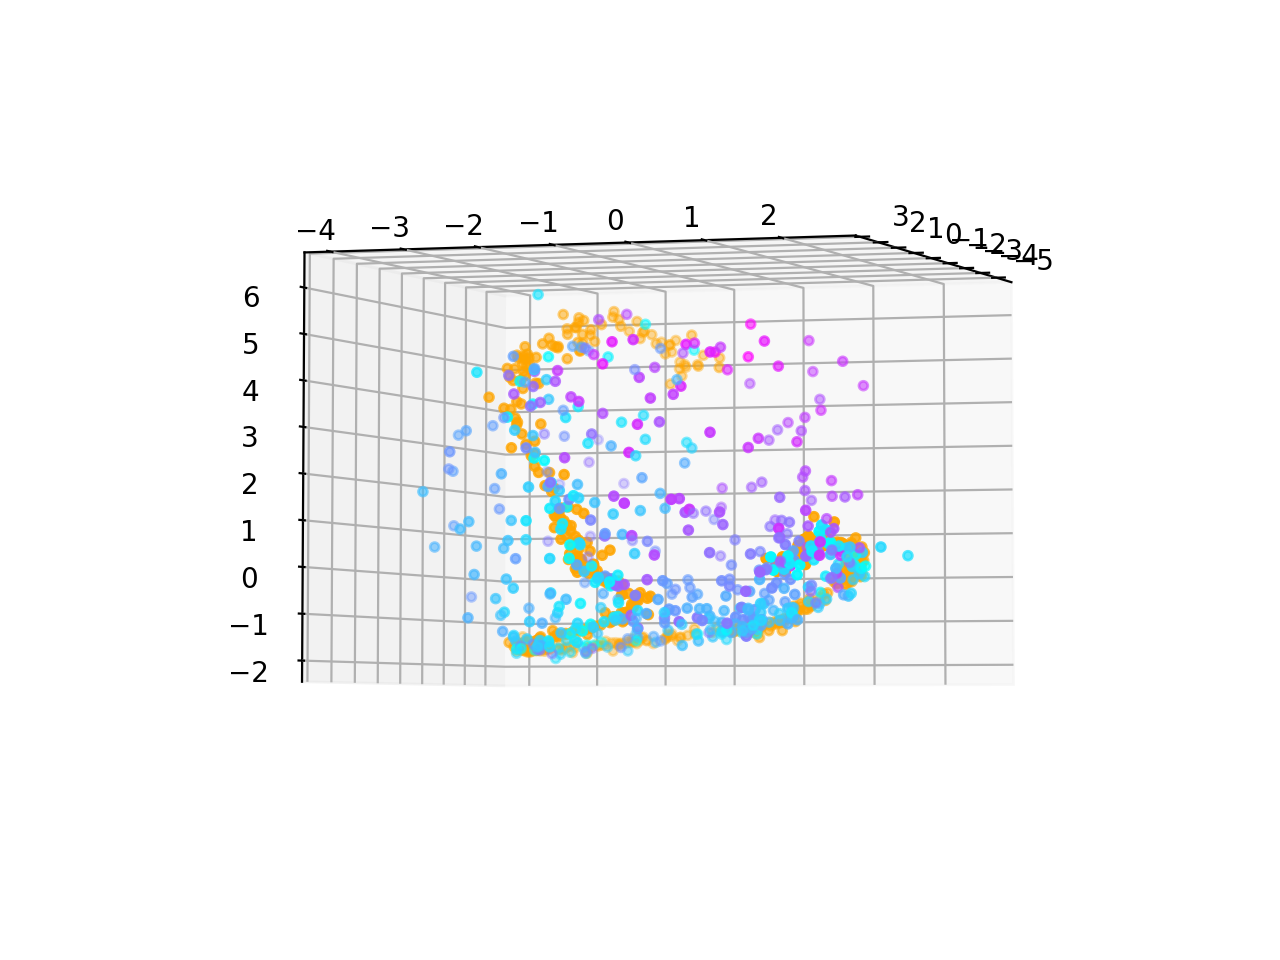

In [325]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(tf[~spectra['simple'], 0], tf[~spectra['simple'], 1], s=10)
f = 10
separations = abs(spectra['depths'][:, 0] - spectra['depths'][:, 1])
ax.scatter(tf[~spectra['simple'], 0][::f], tf[~spectra['simple'], 1][::f], tf[~spectra['simple'], 2][::f], s=10,
           c=separations[~spectra['simple']][::f], cmap='cool')
ax.scatter(tf[spectra['simple'], 0][::f], tf[spectra['simple'], 1][::f], tf[spectra['simple'], 2][::f], s=10,
           c='orange')
# plt.legend(['complex', 'simple'])
# plt.subplot(1, 2, 2)
# plt.scatter(tf[~spectra['simple'], 2], tf[~spectra['simple'], 1], s=10)
# plt.scatter(tf[spectra['simple'], 2], tf[spectra['simple'], 1], s=10)
# plt.legend(['complex', 'simple'])

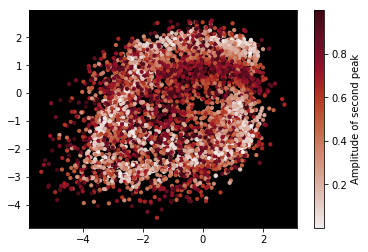

In [326]:
%matplotlib inline
ax = plt.subplot(1, 1, 1, facecolor='black')
plt.scatter(tf[~spectra['simple'], 0],
            tf[~spectra['simple'], 1],
            c=spectra['amps'][~spectra['simple'], 1],
            cmap=cmocean.cm.amp, s=10)
cb = plt.colorbar()
cb.set_label('Amplitude of second peak')

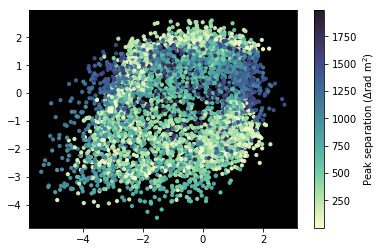

In [327]:
ax = plt.subplot(1, 1, 1, facecolor='black')
separations = abs(spectra['depths'][:, 0] - spectra['depths'][:, 1])
plt.scatter(tf[~spectra['simple'], 0],
            tf[~spectra['simple'], 1],
            c=separations[~spectra['simple']],
            cmap=cmocean.cm.deep, s=10)
cb = plt.colorbar()
cb.set_label('Peak separation ($\\Delta$rad m$^2$)')

In [305]:
svm = sklearn.svm.OneClassSVM(kernel='rbf', gamma=0.5)
svm.fit(tf[spectra['simple']])

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.5, kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [273]:
# X, Y = numpy.mgrid[-2.5:15.0:0.5, -4:10:0.5]
# XY = numpy.stack([X.ravel(), Y.ravel()]).T
# scores = svm.score_samples(XY)

In [306]:
# plt.pcolormesh(X, Y, scores.reshape(X.shape))
# # plt.scatter(tf[~spectra['simple'], 0], tf[~spectra['simple'], 1], s=10)
# # plt.scatter(tf[spectra['simple'], 0], tf[spectra['simple'], 1], s=10, color='black')
# # plt.legend(['complex', 'simple'])

In [333]:
predictions = svm.score_samples(tf)

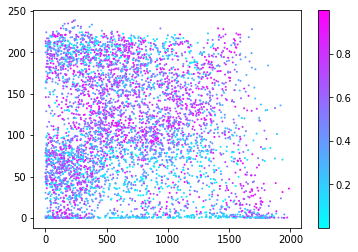

In [334]:
%matplotlib inline
separations = abs(spectra['depths'][:, 0] - spectra['depths'][:, 1])
amps = spectra['amps'][:, 1]
plt.scatter(separations[~spectra['simple']], predictions[~spectra['simple']], s=1, c=amps[~spectra['simple']],
            cmap='cool')
plt.colorbar()

In [286]:
real_spectra = numpy.load('/home/alger/possum/alger/COSMOLOGY_22/all_spectra.npy')

In [287]:
real_labels = numpy.load('/home/alger/possum/alger/COSMOLOGY_22/pixel_labels.npy')

In [288]:
real_spectra_mag = abs(real_spectra)
real_spectra_mag_ = real_spectra_mag / real_spectra_mag.max(axis=1, keepdims=True)
real_spectra_mag_.dtype

dtype('float32')

In [310]:
tf_real_simtrained = pca.transform(real_spectra_mag_)

In [314]:
spectra.keys()

dict_keys(['depths', 'amps', 'simple', 'spectra', 'spectra_noisy', 'fdf_gt', 'sim_fdf', 'targets'])

<IPython.core.display.Javascript object>


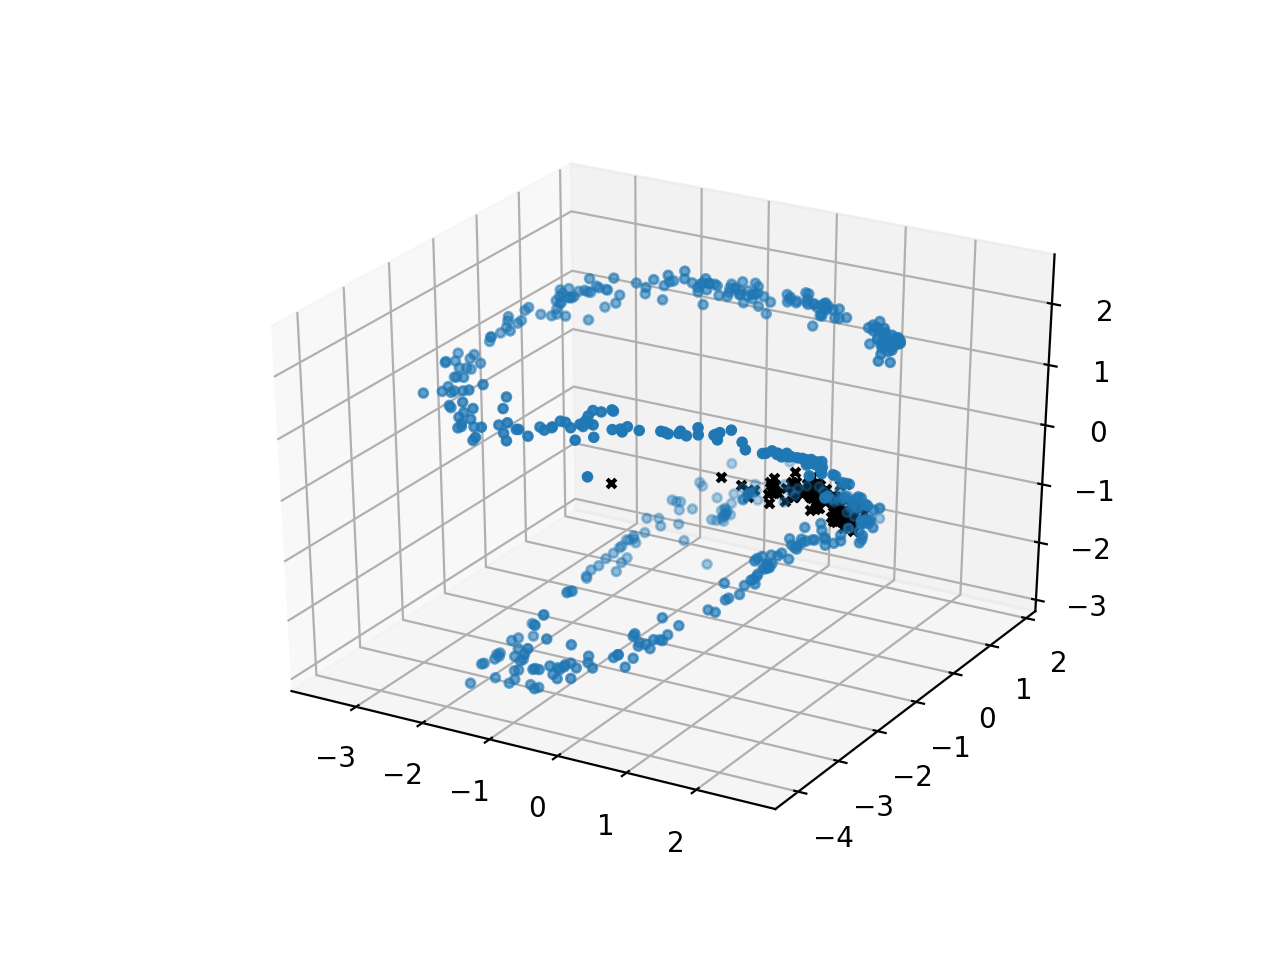

In [316]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tf[spectra['simple'], 0][::10], tf[spectra['simple'], 1][::10], tf[spectra['simple'], 2][::10], s=10)

for i in range(100):
    mask = real_labels == i
    avg = tf_real_simtrained[mask].mean(axis=0)
    plt.scatter(avg[0], avg[1], s=10, c='k', marker='x')

In [138]:
pca_real = CodaPCA.CodaPCA(2, 1e-3, [10, 10], alg=CodaPCA.Alg.CODAAE)

In [139]:
tf_real = pca_real.fit_transform(real_spectra_mag, epochs=100)

[epoch     0] L=262.2983


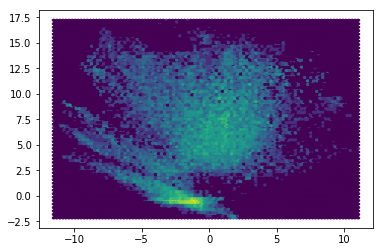

In [140]:
plt.hexbin(tf_real[:, 0], tf_real[:, 1], bins='log')

In [141]:
tf_sim_realtrained = pca_real.transform(features)

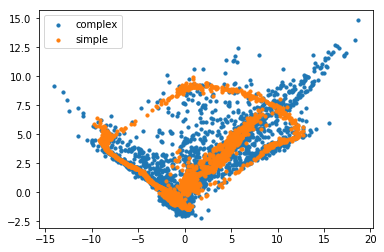

In [142]:
plt.scatter(tf_sim_realtrained[~spectra['simple'], 0], tf_sim_realtrained[~spectra['simple'], 1], s=10)
plt.scatter(tf_sim_realtrained[spectra['simple'], 0], tf_sim_realtrained[spectra['simple'], 1], s=10)
plt.legend(['complex', 'simple'])